## Fitting ALMA CO(2-1) spectra in Abell 2597

I extracted spectra using `casaviewer v4.6`, and saved them as simple ASCII files. The extracted spectra and their associated extraction regions are shown here:  

<img src="regions.png">

Let's fit these spectra with gaussians, so as to better characterize the masses associated with each regional component. This solution requires Adam Ginsburg's [PySpecKit](http://pyspeckit.bitbucket.org/html/sphinx/index.html) which requires Python 2.7 (3.x won't work). 

In [1]:
import sys
import os
import glob

import numpy as np

from astropy.io import ascii
from astropy.table import QTable

from astropy.cosmology import FlatLambdaCDM

import astropy.units as u

import pyspeckit

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.style as style
%matplotlib inline

Make some units and a cosmology:

In [2]:
emission_integral_units_mJy = u.mJy * u.km / u.s
emission_integral_units_Jy = u.Jy * u.km / u.s

xco_unit = u.cm**(-2) * (u.K * u.km * u.s**(-1))**(-1)

cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

## Make your plots pretty

This is best done globally, so that both my custom plotter \& Adam's PySpecKit plotter() output consistent plot styles. 

In [3]:
plt.rcParams.update({'font.size'     : 16,
                    'axes.labelsize' : 16,
                    'legend.fontsize': 16,
                    'xtick.labelsize': 18,
                    'ytick.labelsize': 18,
                    'axes.linewidth' :  2  })
#style.use('ggplot')

## Functions

Make some simple i/o functions for these ascii files: 

In [4]:
def makeSpectrum(file):
    
    # Read the raw ASCII spectrum into an Astropy TABLE object
    rawdata = ascii.read(file)
    
    # Give the columns meaningful names
    if 'col1' in rawdata.columns:
        rawdata.rename_column('col1','Velocity')
    if 'col2' in rawdata.columns:
        rawdata.rename_column('col2', 'FluxDensity')
        
    # Give the new columns proper units. 
    # We'll have to strip them later, because PySpecKit doesn't 
    # like "quantity" objects, but it's useful to have the functionality
    # anyway
    Velocity = rawdata['Velocity'] * (u.km / u.s)
    FluxDensityJy = rawdata['FluxDensity'] * u.Jy

    # Put the flux into mJy 
    FluxDensity = FluxDensityJy.to(u.mJy)
    
    # Manually write the errors. The RMS of the 10 km/s cube
    # is 0.30 mJy / 10 km/s channel. This is the error on the flux.
    # The velocity channel width is +/- 5 km/s, e.g. 10 km/s width. 
    VelErr = ((np.zeros(len(Velocity))) + 5.0) * (u.km / u.s)
    FluxErr = ((np.zeros(len(FluxDensity))) + 0.30) * u.mJy

    # Construct the main Astropy TABLE with Units
    data = QTable([Velocity, FluxDensity, VelErr, FluxErr], names=("Velocity", "Flux Density", "Velocity Error", "Flux Error"))
    
    # Also constuct unit-free versions for passing to PySpecKit
    
    
    flux = FluxDensity.value
    vel = Velocity.value
    
    rms = FluxErr.value
    width = VelErr.value
    
    return data, vel, flux, width, rms

In [5]:
def specfit(vel, flux, rms, guesses=None, figname="fig.pdf"):
    
    sp = pyspeckit.Spectrum(data=flux, error=rms, xarr=vel, xarrkwargs={'unit':'km/s'}, unit='mJy')
    
    # If the user was too lazy to supply a guess, begrudgingly fit a single gaussian 
    # while attempting to pick an intelligent starting point
    if guesses is None:
        amplitude_guess = flux.max()
        center_guess = (flux * vel).sum() / flux.sum() # Try to guess the Gaussian center
        width_guess = flux.sum() / amplitude_guess / np.sqrt(2*np.pi)
        
        guesses = [amplitude_guess, center_guess, width_guess]
        
    
    sp.specfit.multifit(guesses=guesses, negamp=False, renormalize='auto')
    
    # Guesses should take the format of: 
    # guesses = [amplitude_guess, center_guess, width_guess]
    # Multiple components are strung along in one array, e.g. 
    # guesses = [5.,100.,100.,            where this is [amp, center, width] of Gaussian 1
    #           15., -20., 60.,           ... guassian 2
    #           2.5, -200., 20.]          ... gaussian 3 (and so on...)
    
    sp.plotter(errstyle='fill', xmin=-500, xmax=500, ymin=-5, ymax=20)
    sp.specfit.plot_components(add_baseline=False,component_yoffset=-0.2)
    sp.specfit.plotresiduals(axis=sp.plotter.axis,clear=False,yoffset=0,label=False)
    sp.specfit.plot_fit(annotate=False, lw=2.0)
    sp.specfit.plotresiduals(axis=sp.plotter.axis,clear=False,yoffset=0.0,label=False, color='orange')
    
    #sp.specfit.annotate(chi2='optimal')
    
    # Note that this isn't the 'real' chi2! It's something Adam made up! 
    # It uses the fitted model to find all pixels that are above the noise in the spectrum
    # then computes chi^2/n using only those pixels
    
    #chi2 = sp.specfit.optimal_chi2(reduced=True)
    #print(chi2)
    
    components = sp.specfit.get_components()
    #print(components)
    
    # The integral will be in units of mJy * km/s
    integral, error = sp.specfit.integral(direct=True, return_error=True)
    
    mass = gasmass(integral, error)
    
    sp.plotter.savefig(figname)
    print("Saved this figure as %s" % figname)
    
    return components, mass
    
    #emcee_ensemble = sp.specfit.get_emcee()
    #p0 = emcee_ensemble.p0 * (np.random.randn(*emcee_ensemble.p0.shape) / 10. + 1.0)
    #pos,logprob,state = emcee_ensemble.run_mcmc(p0,100)
    
    #sp.specfit.get_components()
    


In [6]:
def gasmass(gaussian_area, gaussian_area_err):
    '''
    Compute a gas mass for Abell 2597. 
    The gaussian area must be in mJy * km/s
    '''
    
    emission_integral = (gaussian_area * emission_integral_units_mJy).to(emission_integral_units_Jy)
    emission_integral_err = (gaussian_area_err * emission_integral_units_mJy).to(emission_integral_units_Jy)
    
    redshift = 0.0821 # Redshift of A2597
    xco = 2.0e20 * xco_unit
    ratio = 3.2  # CO(2-1) to CO(1-0) flux density ratio
    
    xco_mw = 2.0e20 * xco_unit
    ldist = cosmo.luminosity_distance(redshift).to(u.Mpc)
    
    rawmass = 1.05e4 * (xco / xco_mw) * (1 + redshift)**(-1) * (emission_integral / emission_integral_units_Jy) * (ldist/u.Mpc)**2 * (1.0/ratio)
    
    finalmass = rawmass * u.M_sun
       
    return finalmass

In [7]:
def plotter(velocity, flux, width=None, rms=None, title="Remember to Set a Title!"):
    
    fig, ax = plt.subplots(1)
    
    if width is None and rms is None:
        component_number = np.shape(flux)[0]
        for i in range(component_number):
            ax.plot(velocity, flux[i], lw=2.0, color='blue')
    else: 
        ax.plot(velocity, flux, lw=0.5, color='black')
        ax.fill_between(velocity, flux+rms, flux-rms, facecolor='blue', alpha=0.5)
        #ax.fill_betweenx(flux, velocity+width, velocity-width, facecolor='blue', alpha=0.5)
        
    ax.set_xlim([-500,500])
    ax.set_ylim([-5, 20])
    
    ax.set_title(title)
    ax.set_xlabel('Velocity (km / s)')
    ax.set_ylabel('Flux density (mJy)')
    
    #plt.figure()
    #plt.errorbar(velocity, flux, xerr=width, yerr=rms, 
    #         marker='o', markersize=0.5, ls='-', color='black', elinewidth=2, capsize=0)

    #plt.title("CO(2-1) Line Profile")



### Fitting the 'Total' Region

In [8]:
glob.glob('*.txt')

['jet_region_pbcorr.txt',
 'entire_nebula_pbcorr.txt',
 'northern_filaments_pbcorr.txt',
 'southern_filaments_pbcorr.txt']

In [9]:
totalfile = 'entire_nebula_pbcorr.txt'
totaldata, totalvel, totalflux, totalwidth, totalrms = makeSpectrum(totalfile)

invalid value encountered in greater_equal


Saved this figure as total_region.pdf


<Quantity 2130965185.1792624 solMass>

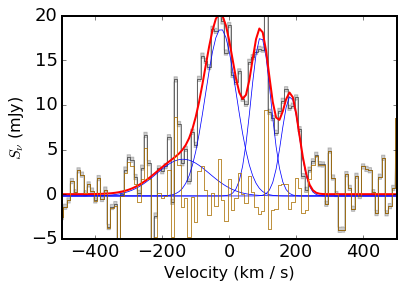

In [10]:
totalguesses = [12., -30., 100., 
                18., 100., 100.,
                12., 180., 50.,
                5., -300., 100.]

total_fit, total_mass = specfit(totalvel, totalflux, totalrms, totalguesses, "total_region.pdf")
total_mass

### Inner Jet Region

In [20]:
jetfile = "jet_region_pbcorr.txt"
jetdata, jetvel, jetflux, jetwidth, jetrms = makeSpectrum(jetfile)

#plotter(vel, flux, width, rms, "Jet Region")


Saved this figure as jet_region.pdf


<Quantity 1760495455.2885838 solMass>

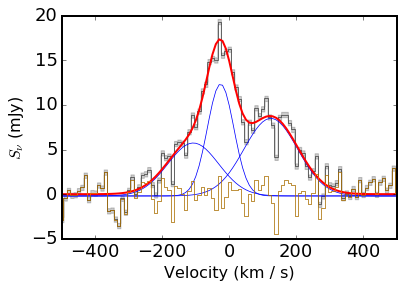

In [21]:
# Amplitude, Center, Width

jetguesses = [5.,100.,100., 
           15., -20., 60.,
           2.5, -200., 20.]

jet_fit, jet_mass = specfit(jetvel, jetflux, jetrms, jetguesses, "jet_region.pdf")
jet_mass

### Southern Filaments

Saved this figure as southern_region.pdf


<Quantity 949285356.9115336 solMass>

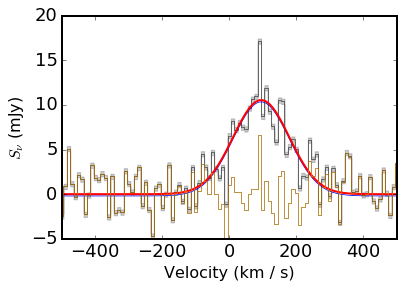

In [15]:
southernfile = 'southern_filaments_pbcorr.txt'
data, vel, flux, width, rms = makeSpectrum(southernfile)

southernguesses = [10., 130., 50.]
                  # 3., 150., 100.]

southern_fit, southern_mass = specfit(vel, flux, rms, southernguesses, "southern_region.pdf")
southern_mass

### Northern Filaments

Saved this figure as northern_region.pdf


<Quantity 461163284.81752086 solMass>

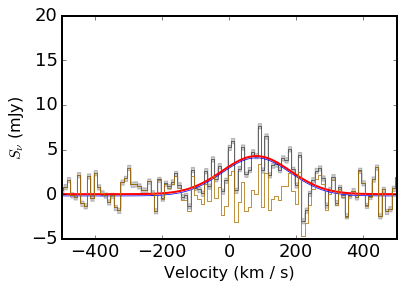

In [16]:
northernfile = 'northern_filaments_pbcorr.txt'
data, vel, flux, width, rms = makeSpectrum(northernfile)

northernguesses = [5., 30., 300.]

northern_fit, northern_mass = specfit(vel, flux, rms, northernguesses, "northern_region.pdf")
northern_mass

### Plot all components that you've fit

In [17]:
all_components = np.concatenate([jet_fit, total_fit, northern_fit, southern_fit], axis=0)
plotter(vel, all_components, title="All fit components")

NameError: name 'jet_fit' is not defined

### Sanity checks

The sum of masses of all three regional components (jet, northern, and southern filaments) should be very close to the total mass. If it's not, you've "missed a spot" in extracting your regions. 

In [18]:
(jet_mass + northern_mass + southern_mass) / total_mass

NameError: name 'jet_mass' is not defined

This is close enough for our purposes, as we're only trying to roughly assess the *rough fractional contribution* of each component to the total mass. 

The total mass should also be consistent with Tremblay et al. 2016!

In [19]:
tremblay16_mass = 1.80e9 * u.M_sun
tremblay16_mass_err = 0.19e9 * u.M_sun

upperbound = tremblay16_mass + tremblay16_mass_err
lowerbound = tremblay16_mass - tremblay16_mass_err

if total_mass >= lowerbound and total_mass <= upperbound:
    print("The total mass (%s) is consistent with Tremblay et al. 2016" % total_mass)
else:
    print("Total mass (%s) inconsistent with Tremblay et al. 2016!" % total_mass) 

Total mass (2130965185.18 solMass) inconsistent with Tremblay et al. 2016!


### Wrapping up

We're looking pretty good. The jet, northern, and southern regions, respectively accounts for (as a percent of total): 

In [20]:
(jet_mass / total_mass) * 100.0

<Quantity 70.76045343455452>

In [21]:
(northern_mass / total_mass) * 100.0

<Quantity 21.641052046503827>

In [22]:
(southern_mass / total_mass) * 100.0

<Quantity 44.54720159267535>

So we'll round this to 70% + 20% + 10% for the jet, northern, and southern regions, respectively. 

In [23]:
1.3 + 0.42 + 0.22

1.94

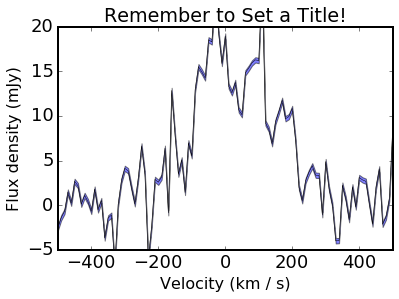

In [24]:
plotter(totalvel, totalflux, totalwidth, totalrms)